In [74]:
# Save fonts into pdf
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Set rcParams
matplotlib.rcParams.update({'font.size': 6, 'axes.linewidth': 0.5, 'xtick.major.width': 0.5, 'xtick.minor.width': 0.5, 
                            'ytick.major.width': 0.5,'ytick.minor.width': 0.5, 'xtick.major.pad':2,'ytick.major.pad':2})
matplotlib.rcParams.update({'font.family':'sans-serif','font.sans-serif':['Arial'], 'mathtext.default':'sf','mathtext.fontset':'custom'})

matplotlib.rcParams.update({'savefig.transparent':True})

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tnrange

In [3]:
import scipy.integrate

In [4]:
import os

# Timer implementation

In [5]:
hill = lambda x, k_d, n: np.power(x,n)/(k_d**n + np.power(x,n))
perfect_step = lambda x, k_d: x >= k_d

In [6]:
k_deg = np.array([1000, 100])
k_on = np.array([1500, 200])
k_off = np.array([250, 20])


def accumulationToBoundTimer(t,y, k_d):
    k_pr = 5
    dydt = np.zeros(4)
    dydt[0] = -k_deg[0]*y[0]*hill(y[3], 0.3, 10)
    dydt[1] = k_pr*y[0]*(1-y[1]) -k_deg[1]*y[1]*(1-y[0])
    dydt[2] = -k_off[0]*y[2] + k_on[0]*perfect_step(y[1], k_d)*(1-y[2])
    dydt[3] = -k_off[1]*y[3] + k_on[1]*(1-y[3])*hill(y[2], 0.9,20)
    return dydt

## Time course of timer components (Ext. Fig. 3B)

In [10]:
dt = 1e-4 # Time step size (s)
T = 0.2 # Total time of simulation
t = np.arange(0, int(T/dt))*dt

y0 = np.array([1, 0, 0, 0])
sol = scipy.integrate.solve_ivp(lambda t,y: accumulationToBoundTimer(t,y,0.4), (0, 0.2), y0, dense_output=True)
sol_y = sol.sol(t)

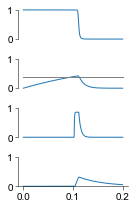

In [34]:
plt.figure(figsize=(2,3))
ax = plt.subplot(4,1,1)

ax.xaxis.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.ylim([0,1])

plt.plot(t, sol_y[0,:], lw=1, clip_on=False)


ax = plt.subplot(4,1,2)
plt.plot(t, sol_y[1,:], lw=1, clip_on=False)
plt.plot([0, 0.2], [0.4,]*2, lw=1, c=(0.5, 0.5, 0.5, 1))
plt.ylim([0, 1])

ax.xaxis.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax =plt.subplot(4,1,3)

plt.plot(t, sol_y[2,:], lw=1, clip_on=False)
ax.xaxis.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.ylim([0, 1])

ax = plt.subplot(4,1,4)
plt.plot(t, sol_y[3,:], lw=1, clip_on=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylim([0, 1])

plt.xticks([0, 0.1, 0.2])

plt.tight_layout();

# PF-CF interval distribution

In [35]:
dt = 1e-4
tt = np.arange(0, int(0.2/dt))*dt

# Use example bimodal distribution (see text)
distr = np.exp(-(tt-0.05)**2/(2*0.05**2)) + 2*np.exp(-(tt-0.15)**2/(2*0.01**2))
distr /=np.sum(distr)

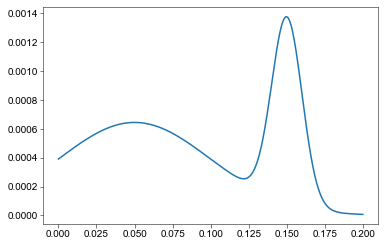

In [36]:
plt.plot(tt, distr)

In [37]:
cdf = np.cumsum(distr/np.sum(distr))

# Inverse CDF
get_interval = lambda r: np.interp(r, cdf, tt)
get_interval_NN = lambda r: np.array(np.round(get_interval(r)*10000)/10000/dt, dtype=int)

In [60]:
# Median timing interval
get_interval(0.5)

0.08831181202926286

# Simulate ATTRAP

In [38]:
# Simulation parameters
its = 5000 # PF/CF pair presentations per simulation
N_sims = 10

dt = 1e-4 # Time step size (s)
T = 0.2 # Total simulation time (s)
t = np.arange(0, int(T/dt))*dt

dthresh_ = 1e-3 # beta, learning rate

thresholds = np.zeros((N_sims, its))
peaks = np.zeros((N_sims, its))
fwhm = np.zeros((N_sims, its, 2)) # Full width at half max of eligibility window through each simulation

min_thresh = 1e-3
max_thresh = 0.6
for n in tnrange(N_sims):
    y0 = np.array([1, 0, 0, 0])
    sol = scipy.integrate.solve_ivp(lambda t,y: accumulationToBoundTimer(t,y,min_thresh), (0, 0.2), y0, dense_output=True)
    sol_y = sol.sol(t)

    thresholds[n, 0] = 1e-3
    for it in tnrange(its-1, leave=False):
        # Generate PF/CF interval time
        cf_time = get_interval_NN(np.random.rand())

        # Calculate value of timer adjustment window
        lower_threshold =  -hill(sol_y[1,cf_time]*(sol_y[2,cf_time]<1e-3), 0.025, 5)*sol_y[0,cf_time] 
        raise_threshold = hill(sol_y[3,cf_time]*hill((1-sol_y[0,cf_time]), 0.9, 20), 0.025, 5) 

        # Move threshold
        dthresh = (lower_threshold+raise_threshold)*dthresh_
        thresholds[n,it+1] = np.minimum(np.maximum(thresholds[n,it] + dthresh, min_thresh), max_thresh)

        # Solve for timer dynamics given new threshold for next PF/CF pair
        sol = scipy.integrate.solve_ivp(lambda t,y: accumulationToBoundTimer(t,y,thresholds[n, it]), (0, 0.2), y0, dense_output=True)
        sol_y = sol.sol(t)
    
        # Time of peak eligibility
        peaks[n,it] = t[np.argmax(sol_y[2,:])]
        
        # Calculate bounds of full-width-at-half-max of eligibility window
        inds_pos = np.argwhere(sol_y[2,:]>0.5*np.max(sol_y[2,:]))
        fwhm[n,it,:] = np.concatenate((t[inds_pos[0]], t[inds_pos[-1]]))

In [39]:
thresholds_mu = np.mean(thresholds, axis=0)
thresholds_std = np.std(thresholds, axis=0)

peaks_mu = np.mean(peaks, axis=0)[:-1]
peaks_std = np.std(peaks, axis=0)[:-1]

In [40]:
fwhm_low = np.mean(fwhm[:,:,0], axis=0)[:-1]
fwhm_high = np.mean(fwhm[:,:,1], axis=0)[:-1]

## Extended figure 3E

In [42]:
thresholds_mu_mu = np.mean(thresholds_mu[1000:]) 

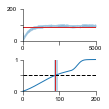

In [123]:
plt.figure(figsize=(1.5,1.5))

ax = plt.subplot(2,1,1)
# Time course of full-width-at-half-max (FWHM) of eligibility window averaged over simulations
plt.fill_between(np.arange(its-1),fwhm_low, fwhm_high, color='C0', alpha=0.3, linewidth=None )
plt.plot([0, 5000], [0.0882,]*2, c='C3', lw=1)
plt.xlim([0, 5000])
plt.ylim([0, 0.2])
plt.xticks([0, 2500, 5000], [0,'',5000])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.yticks([0, 0.1, 0.2], [0, '', 200])

ax = plt.subplot(2,1,2)
# Cumulative distribution function of PF/CF interval distribution
plt.plot(tt, cdf, lw=1, clip_on=False)
# Median is CDF evaluated at 0.5
plt.plot([0, 0.2], [0.5, 0.5], 'k--', lw=1)
# Plot FWHM of eligibility using threshold value averaged over final 4000 trials across 10 simulations
plt.fill_between([np.mean(fwhm_low[1000:]), np.mean(fwhm_high[1000:])], [0,]*2, [1,]*2,alpha=0.3)
# Median interval
plt.plot([get_interval(0.5),]*2, [0, 1], c='C3', lw=1)
plt.xlim([0, 0.2])
plt.ylim([0, 1])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticks([0, 0.1, 0.2])
ax.set_xticklabels([0, 100, 200])

plt.yticks([0, 0.5, 1], [0, '', 1])
plt.tight_layout();

## Eligibility window contains median of PF/CF interval distribution (Fig. 3E)

In [67]:
t_dense = np.arange(0, int(0.2/1e-4))*1e-4

sol_plot = scipy.integrate.solve_ivp(lambda t,y: accumulationToBoundTimer(t,y,thresholds_mu_mu), (0, 0.2), y0, dense_output=True)
sol_y_plot = sol_plot.sol(t_dense)

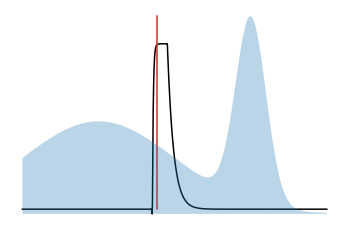

In [75]:
plt.plot(t_dense, sol_y_plot[2,:], c='k')
plt.plot([get_interval(0.5),]*2, [0, 1], c='C3') # Median interval
plt.axis('off')
ax = plt.twinx()
plt.fill_between(tt, 0, distr/np.sum(distr), alpha=0.3);
plt.axis('off');

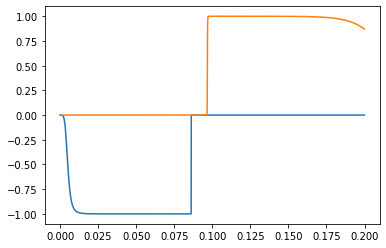

In [436]:
plt.plot(t, -hill(sol_y_plot[1,:]*(sol_y_plot[2,:]<1e-3), 0.025, 5)*sol_y_plot[0,:])
plt.plot(t, hill(sol_y_plot[3,:]*hill((1-sol_y_plot[0,:]), 0.9, 20), 0.025, 5))

# Idealized model

In [82]:
idealized_integrator = lambda t, theta: np.exp(-(t-theta)**2/(2*0.005**2))

Idealized model consists of an eligibility window given by a Gaussian of comparable width to the window resulting from the accumulation-to-bound timer, where the parameter tuned by ATTRAP is the center of the Gaussian.

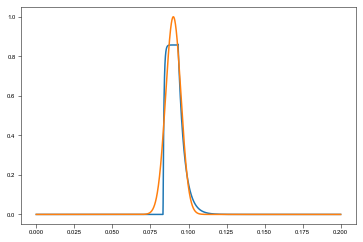

In [86]:
plt.plot(t, sol_y[2,:])
plt.plot(t, idealized_integrator(t, 0.09))

In [111]:
# Simulation parameters
its = 5000
N_sims = 10

dt = 1e-4
T = 0.2
t = np.arange(0, int(T/dt))*dt

dthresh_ = 1e-3

thresholds_ideal = np.zeros((N_sims, its))

min_thresh = 1e-3
max_thresh = 0.6
for n in tnrange(N_sims):
    integrator = idealized_integrator(t, min_thresh)

    thresholds_ideal[n, 0] = 1e-3
    for it in tnrange(its-1, leave=False):
        cf_time = get_interval(np.random.rand())

        # Idealized ATTRAP rule: lower threshold if CF occurs before current peak time
        # and raise threshold if CF occurs after current peak time
        lower_threshold = -1*(cf_time < thresholds_ideal[n, it])
        raise_threshold = cf_time > thresholds_ideal[n, it]

        dthresh = (lower_threshold+raise_threshold)*dthresh_
        thresholds_ideal[n,it+1] = np.minimum(np.maximum(thresholds_ideal[n,it] + dthresh, min_thresh), max_thresh)

        integrator = idealized_integrator(t, thresholds[n, it+1])

In [112]:
thresholds_ideal_mu = np.mean(thresholds_ideal, axis=0)
thresholds_ideal_std = np.std(thresholds_ideal, axis=0)

## Extended figure 3F

In [115]:
thresholds_ideal_mu_mu = np.mean(thresholds_ideal_mu[1000:])

In [116]:
final_integrator = idealized_integrator(t, thresholds_ideal_mu_mu)

# Full-width-at-half-max of eligibility window generated by 
# averaging threshold value of last 4000 PF/CF pairings across 10 simulations
indpos = np.argwhere(final_integrator>0.5*final_integrator)
t[inds_pos[0]], t[inds_pos[-1]]

(array([0.0837]), array([0.0958]))

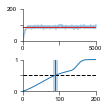

In [124]:
plt.figure(figsize=(1.5,1.5))

ax = plt.subplot(2,1,1)
plt.fill_between(np.arange(its),thresholds_ideal_mu-thresholds_ideal_std, thresholds_ideal_mu+thresholds_ideal_std, color='C0', alpha=0.3, linewidth=None )
plt.plot([0, 5000], [0.0882,]*2, c='C3', lw=1)
plt.xlim([0, 5000])
plt.ylim([0, 0.2])
plt.xticks([0, 2500, 5000], [0,'',5000])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.yticks([0, 0.1, 0.2], [0, '', 200])

ax = plt.subplot(2,1,2)
plt.plot(tt, cdf, lw=1, clip_on=False)
plt.plot([0, 0.2], [0.5, 0.5], 'k--', lw=1)
plt.fill_between(np.concatenate((t[inds_pos[0]], t[inds_pos[-1]])), [0,]*2, [1,]*2,alpha=0.3)
plt.plot([get_interval(0.5),]*2, [0, 1], c='C3', lw=1)
plt.xlim([0, 0.2])
plt.ylim([0, 1])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticks([0, 0.1, 0.2])
ax.set_xticklabels([0, 100, 200])

plt.yticks([0, 0.5, 1], [0, '', 1])
plt.tight_layout();

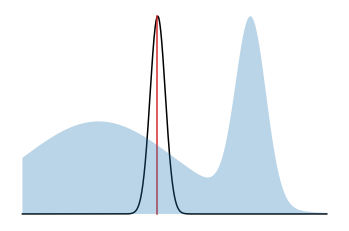

In [120]:
plt.plot(t, final_integrator, c='k')
plt.plot([0.0883,]*2, [0, 1], c='C3')
plt.axis('off')
ax = plt.twinx()
plt.fill_between(tt, 0, distr/np.sum(distr), alpha=0.3);
plt.axis('off');